# Estimating cost-of-living impacts on healthcare activity and spend over Winter 2022/23 

## Overview

The aim of this project is to model how the cost of living (CoL) crisis might impact health service demand this winter. The models were devloped using data from the Bristol, North Somerset and South Gloucestershire (BNSSG) [System Wide Dataset](https://bnssghealthiertogether.org.uk/population-health-management/) (SWD): a linked patient-level data set containing information  across Primary Care, Secondary Care, Mental Health and Community Services for over 1 million members of the BNSSG population. 

For modelling purposes we defined *winter* as the period 1st October to 31st March and assumed the impact of CoL would result in all members of the population moving down one Index of Multiple Deprivation (IMD) decile. The models use, as an independent variable, each person's Cambridge Multimorbidity Score ($cs$). The dependant variables are activity and spend in each of the following healthcare settings:

- Primary Care
- Prescriptions
- Mental Health Outpatient (OP)
- Mental Health Inpatient (IP)
- Community Care
- 999 calls$*$ 
- 111 calls
- Secondary Care OP
- Secondary Care IP
- Emergency Department attendances

$*$ no cost data available for 999 calls

## Methods

### Data

Data was obtained from the SWD. Data from winter 2021 was used for training the models and data from 2022, with each person's $cs$ updated to the current value, was used for forecasting what might happen this winter given CoL. The population consisted of a core set of 886,489 individuals that have been residing in BNSSG since, at least, October 2021.

For each member of the population, the following variables were extracted from the SWD:

- IMD 
- $cs$ in October 2021
- Total number of contacts with each healthcare setting between 01/10/21 and 31/03/22
- Total spend in each healthcare setting between 01/10/21 and 31/03/22
- $cs$ in July 2022$*$

$*$ This represents the most recent value of $cs$ available for our population


### Model Development

We developed a seperate model for each IMD decile, healthcare setting and output (activity and spend) with $cs$ as an independent variable. Specifically we:

- Used logistic regressions (LRs) to predict whether a person would have any contact with each healthcare setting during the winter period based on their $cs$. The output of each LR was a vector of propabilities, $p$, representing the probability of any contact with the healthcare setting for each individual in the population.
- Used Poisson regressions (PRs) to predict the total number (spend) of winter contacts with each healthcare setting using $p$ and $cs$ as independent variables.

Models were fit to data from winter 2021. Model performance was evaluated using 5-fold cross validation: the models were trained on 80% of the data and performance was assessed on the remaining 20%. This process was repeated 5 times with every member of the population being in the validation set (20% of the data) exactly once. The mean absolute error (MAE) was used to measure model performance. 

All models were subsequently re-trained on the whole population to be used for forecasting activity and spend in winter 2022.

### Winter 2022

#### Baseline

Models trained on data from 2021 were applied to 2022 data (updated values of $cs$, IMD decile remains unchanged). The output of the models was used as a baseline projection for winter 2022, i.e. expected activity and spend without the CoL crisis.  

#### CoL 

To model the CoL crisis, we assumed each person's IMD decile would decrease by 1. As we developed seperate models for each IMD decile, we modelled a decrease in IMD by applying the models trained on people with IMD = $I-1$ to the population with IMD = $I$. As IMD decile cannot go below 1, for members of the population with an IMD of 1 we used baseline projections and therefore did not account for the impact of the CoL crisis on those living in the most deprived areas. 
 
 
## Using this Notebook

This notebook contains all code to re-run the analysis. To keep it tidy, functions to fit and apply the models are contained in a seperate file `functions.ipynb` which should not need to be edited. As the data we have used cannot be shared, we have provided all column headings and variable descriptions in `Data Description` (see below). This can be used as a guide for analysts wishing to run this code on their own local data. 

## Import Libraries 

In [1]:
import os
import pandas as pd
import numpy as np
import fnmatch
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib as mpl
plt.style.use('ggplot')

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import TweedieRegressor

from sklearn.metrics import mean_absolute_error as mae
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_columns', None)

Matplotlib is building the font cache; this may take a moment.


In [2]:
%run functions.ipynb

## Import data

In [3]:
dta = pd.read_csv('clean_data.csv',index_col=0)

## Data Description 

### Variables 

All variables relating to activity and spend correspond to the total during winter 2021 (1st October 21 - 31st March 22) for each person in the population.

#### Activity

- **act_gp_winter**: primary care contacts

- **act_mh_winter_op**: mental health outpatient contacts

- **act_mh_winter_ip**: mental health inpatient contacts

- **act_communtiy_winter**: community care contacts

- **act_111_winter**: 111 calls

- **act_999_winter**: 999 calls

- **act_secondary_winter_op**: secondary care outpatient contacts

- **act_secondary_winter_ae**: emergency department contacts

- **act_secondary_winter_ip**: secondary care inpatient contacts (including maternity)

- **act_prescription_winter**: prescriptions


#### Spend 

- **cost_gp_winter**: primary care spend

- **cost_mh_winter_op**: mental health outpatient spend

- **cost_mh_winter_ip**: mental health inpatient spend

- **cost_communtiy_winter**: community care spend

- **cost_111_winter**: 111 calls spend

- **cost_secondary_winter_op**: secondary care outpatient spend

- **cost_secondary_winter_ae**: emergency department spend

- **cost_secondary_winter_ip**: secondary care inpatient spend (including maternity)

- **cost_prescription_winter**: prescriptions spend

#### IMD and $CS$

- **wd_imd_decile_19**: IMD decile of LSOA in which a person resides

- **cs_21**: Cambridge Score October 2021

- **cs_22**: Cambridge Score July 2022

### Population 

In [4]:
dta.describe()

,act_gp_winter,act_mh_winter_op,act_mh_winter_ip,act_community_winter,act_111_winter,act_999_winter,act_secondary_winter_op,act_secondary_winter_ae,act_secondary_winter_ip,act_prescription_winter,cost_gp_winter,cost_mh_winter_op,cost_mh_winter_ip,cost_community_winter,cost_111_winter,cost_secondary_winter_op,cost_secondary_winter_ae,cost_secondary_winter_ip,cost_prescription_winter,wd_imd_decile_19,age,nhs_number,cs_21,cs_22
count,864673.00,864673.00,864673.00,864673.00,864673.00,864673.00,864673.00,864673.00,864673.00,864673.00,864673.00,864673.00,864673.00,864673.00,864673.00,864673.00,864673.00,864673.00,864673.00,864673.00,864673.00,864673.00,864673.00,864673.00
mean,2.79,0.18,0.00,0.44,0.09,0.05,0.81,0.15,0.13,8.10,57.20,27.85,8.53,44.28,1.34,38.42,20.53,175.46,65.89,5.89,39.48,9010736292.69,0.42,0.39
std,4.54,1.70,0.02,5.04,0.50,0.43,2.51,0.54,1.32,23.33,126.68,306.36,596.63,547.18,7.63,148.42,90.10,1298.48,244.59,2.95,22.73,21848180.28,0.84,0.81
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-8207.94,0.00,0.00,0.00,9000000000.00,0.00,0.00
25%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3.00,22.00,9000558279.00,0.00,0.00
50%,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.43,6.00,38.00,9001173104.00,0.00,0.00
75%,4.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,7.00,68.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,31.66,9.00,57.00,9003391445.00,0.47,0.47
max,139.00,151.00,3.00,573.00,124.00,85.00,121.00,93.00,154.00,2074.00,5240.80,27509.63,106149.40,68238.36,1896.66,14845.00,15444.00,378923.80,74963.38,10.00,108.00,9073591513.00,11.65,11.51


### Activity vs IMD 

In [5]:
titles2new = dict(zip(['111', '999','community', 'gp',
                       'mh ip','mh op','prescription',
                       'secondary ae','secondary ip','secondary op'],
                      ['111 Calls','999 Calls', 'Community Care',
                      'Primary Care','Mental Health IP','Mental Health OP',
                       'Prescriptions', 'Emergency Care','Secondary IP', 'Secondary OP']))

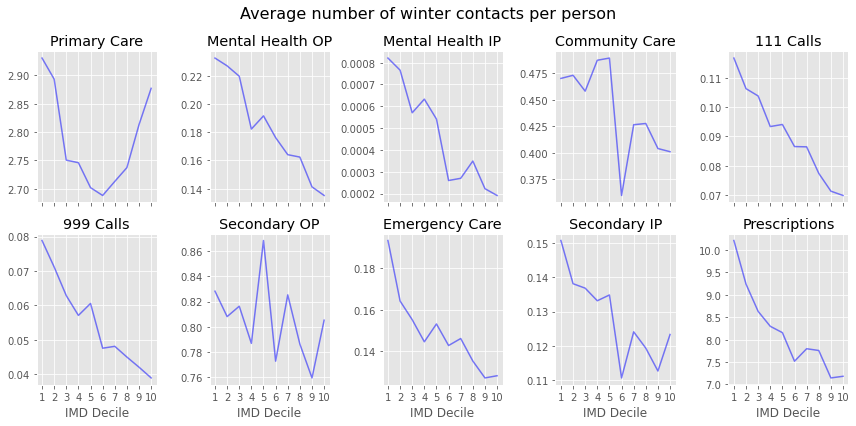

In [6]:
fig,ax = plt.subplots(2,5, figsize=(12,6), sharex='col')
fig.suptitle("Average number of winter contacts per person", fontsize=16)
cols = [c for c in dta.columns if 'act' in c]

ax_list = np.ravel(ax)

for i,ax in enumerate(ax_list):
    to_plot,x = [],[]
    for imd, group in dta.groupby('wd_imd_decile_19'):
        
        if imd<1:
            continue
        to_plot.append(group[cols[i]].mean())
        x.append(imd)
        
    ax.plot(x,to_plot, color='b', alpha=0.5)
   
    
    title = (' ').join(cols[i].split('_')[1:]).replace(' winter','')
    
    ax.set_title(titles2new[title])
    ax.set_xticks(np.arange(1,11))
    if i>4:
        ax.set_xlabel('IMD Decile')
        
plt.tight_layout()
plt.show()

### Spend vs IMD 

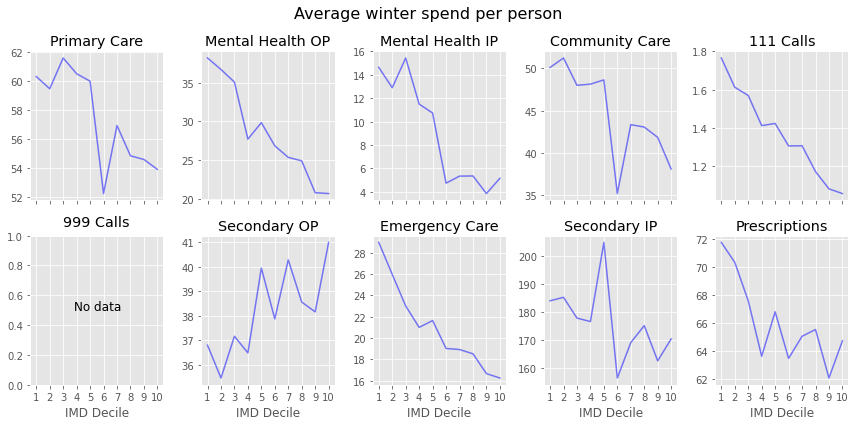

In [7]:
fig,ax = plt.subplots(2,5, figsize=(12,6), sharex='col')

fig.suptitle("Average winter spend per person", fontsize=16)

cols = [c for c in dta.columns if 'cost' in c]

ax_list = np.ravel(ax)

for i,ax in enumerate(ax_list):
    
    if i==5:

        ax.set_title('999 Calls', pad=10)
        ax.text(3.8,0.5,'No data', fontsize=12)
        ax.set_xlabel('IMD Decile')
        continue
        
    if i>5:
        
        i = i-1
        
    to_plot,x = [],[]
    for imd, group in dta.groupby('wd_imd_decile_19'):
        
        if imd<1:
            continue

            
        to_plot.append(group[cols[i]].mean())
        x.append(imd)
        
    ax.plot(x,to_plot, color='b', alpha=0.5)
   
    
    title = (' ').join(cols[i].split('_')[1:]).replace(' winter','')
    
    ax.set_title(titles2new[title])
    ax.set_xticks(np.arange(1,11))
    if i>4:
        ax.set_xlabel('IMD Decile')
        
plt.tight_layout()
plt.show()

## Prepare Data

In [8]:
targets = [c for c in dta.columns if 'winter' in c]

In [9]:
targets

['act_gp_winter',
 'act_mh_winter_op',
 'act_mh_winter_ip',
 'act_community_winter',
 'act_111_winter',
 'act_999_winter',
 'act_secondary_winter_op',
 'act_secondary_winter_ae',
 'act_secondary_winter_ip',
 'act_prescription_winter',
 'cost_gp_winter',
 'cost_mh_winter_op',
 'cost_mh_winter_ip',
 'cost_community_winter',
 'cost_111_winter',
 'cost_secondary_winter_op',
 'cost_secondary_winter_ae',
 'cost_secondary_winter_ip',
 'cost_prescription_winter']

### Add binary variables for LR target 

In [10]:
for col in targets:
    
    dta[f'{col}_binary'] = [int(min(1,c)) for c in dta[col].values]

### Split into training and forecasting data 

In [11]:
dta_train = dta[['wd_imd_decile_19','cs_21'] + targets + 
               [c for c in dta.columns if 'binary' in c]]

dta_train.rename(columns = {'cs_21':'cambridge_score'}, inplace=True)

dta_forecast = dta[['wd_imd_decile_19','cs_22']]

dta_forecast.rename(columns = {'cs_22':'cambridge_score'}, inplace=True)

## Activity Models 

In [12]:
activity_targets = [c for c in dta.columns if 'act' in c and 'binary' not in c]

In [13]:
activity_targets

['act_gp_winter',
 'act_mh_winter_op',
 'act_mh_winter_ip',
 'act_community_winter',
 'act_111_winter',
 'act_999_winter',
 'act_secondary_winter_op',
 'act_secondary_winter_ae',
 'act_secondary_winter_ip',
 'act_prescription_winter']

### Model Development 

In [14]:
%%time

vars_ = ['wd_imd_decile_19','cambridge_score']
folds = 5

act_results = cross_validate(dta_train, vars_, activity_targets, folds)

Starting act_gp_winter, fold 1
Starting act_mh_winter_op, fold 1
Starting act_mh_winter_ip, fold 1
Starting act_community_winter, fold 1
Starting act_111_winter, fold 1
Starting act_999_winter, fold 1
Starting act_secondary_winter_op, fold 1
Starting act_secondary_winter_ae, fold 1
Starting act_secondary_winter_ip, fold 1
Starting act_prescription_winter, fold 1
1 folds completed 


Starting act_gp_winter, fold 2
Starting act_mh_winter_op, fold 2
Starting act_mh_winter_ip, fold 2
Starting act_community_winter, fold 2
Starting act_111_winter, fold 2
Starting act_999_winter, fold 2
Starting act_secondary_winter_op, fold 2
Starting act_secondary_winter_ae, fold 2
Starting act_secondary_winter_ip, fold 2
Starting act_prescription_winter, fold 2
2 folds completed 


Starting act_gp_winter, fold 3
Starting act_mh_winter_op, fold 3
Starting act_mh_winter_ip, fold 3
Starting act_community_winter, fold 3
Starting act_111_winter, fold 3
Starting act_999_winter, fold 3
Starting act_secondary_wint

### Train on all data and forecast 

In [15]:
%%time

vars_ = ['wd_imd_decile_19','cambridge_score']

act_results = predict_all(dta_train, dta_forecast, activity_targets, vars_, act_results)

Starting act_gp_winter
1 pods completed 


Starting act_mh_winter_op
2 pods completed 


Starting act_mh_winter_ip
3 pods completed 


Starting act_community_winter
4 pods completed 


Starting act_111_winter
5 pods completed 


Starting act_999_winter
6 pods completed 


Starting act_secondary_winter_op
7 pods completed 


Starting act_secondary_winter_ae
8 pods completed 


Starting act_secondary_winter_ip
9 pods completed 


Starting act_prescription_winter
10 pods completed 


Wall time: 1min 31s


### Results

In [16]:
act_results = act_results.set_index(pd.Index(['Primary Care','Mental Health OP', 'Mental Health IP', 'Community Care',
                            '111 Calls', '999 Calls',
                              'Secondary Care OP','Emergency Dept', 'Secondary Care IP', 'Prescriptions']))

In [17]:
act_results

,2021 Total,K-fold MAE,Training MAE,2021 Predicted,2022 Baseline,CoL,% change CoL
Primary Care,2411211,2.64 +/- 0.01,2.64,2409640,2412493,2411540,-0.04
Mental Health OP,154534,0.34 +/- 0.0,0.34,154398,154441,163101,5.61
Mental Health IP,377,0.0 +/- 0.0,0.00,377,377,424,12.47
Community Care,377616,0.76 +/- 0.01,0.76,377419,382688,385587,0.76
111 Calls,76757,0.17 +/- 0.0,0.17,76704,76705,80569,5.04
999 Calls,46455,0.1 +/- 0.0,0.10,46387,46394,49667,7.05
Secondary Care OP,696476,1.19 +/- 0.0,1.19,696042,697061,695053,-0.29
Emergency Dept,127192,0.26 +/- 0.0,0.26,127055,127059,132128,3.99
Secondary Care IP,110437,0.23 +/- 0.0,0.23,110370,110430,111534,1.00
Prescriptions,7002032,6.25 +/- 0.02,6.25,6998437,7067464,7317739,3.54


### Comments

The MAE during model development is low for all healthcare settings. It is greatest for settings with a large number of contacts (Primary Care and Prescriptions) as would be expected. 

Comparing `2021 Total` and `2021 Predicted` we see that the models are predicting the total number of contacts in 2021 very well for all healthcare settings.

The values for `2022 Baseline` are different to the `2021 Total` and `2021 Predicted`, reflecting changes in Cambridge Score over the past 12 months.

Increases due to the CoL crises (`% change CoL`) are greatest for Mental Health IP (+ 12.9%) and 999 calls (+7.0%). 

### Save 

In [18]:
act_results.to_excel('activity_model_results.xlsx')

## Cost models 

In [19]:
cost_targets = [c for c in dta.columns if 'cost' in c and 'binary' not in c]

In [20]:
cost_targets

['cost_gp_winter',
 'cost_mh_winter_op',
 'cost_mh_winter_ip',
 'cost_community_winter',
 'cost_111_winter',
 'cost_secondary_winter_op',
 'cost_secondary_winter_ae',
 'cost_secondary_winter_ip',
 'cost_prescription_winter']

### Model Development 

In [21]:
%%time

vars_ = ['wd_imd_decile_19','cambridge_score']
folds = 5

cost_results = cross_validate(dta_train, vars_, cost_targets, folds)

Starting cost_gp_winter, fold 1
Starting cost_mh_winter_op, fold 1
Starting cost_mh_winter_ip, fold 1
Starting cost_community_winter, fold 1
Starting cost_111_winter, fold 1
Starting cost_secondary_winter_op, fold 1
Starting cost_secondary_winter_ae, fold 1
Starting cost_secondary_winter_ip, fold 1
Starting cost_prescription_winter, fold 1
1 folds completed 


Starting cost_gp_winter, fold 2
Starting cost_mh_winter_op, fold 2
Starting cost_mh_winter_ip, fold 2
Starting cost_community_winter, fold 2
Starting cost_111_winter, fold 2
Starting cost_secondary_winter_op, fold 2
Starting cost_secondary_winter_ae, fold 2
Starting cost_secondary_winter_ip, fold 2
Starting cost_prescription_winter, fold 2
2 folds completed 


Starting cost_gp_winter, fold 3
Starting cost_mh_winter_op, fold 3
Starting cost_mh_winter_ip, fold 3
Starting cost_community_winter, fold 3
Starting cost_111_winter, fold 3
Starting cost_secondary_winter_op, fold 3
Starting cost_secondary_winter_ae, fold 3
Starting cost_se

### Train on all data and forecast 

In [22]:
%%time

vars_ = ['wd_imd_decile_19','cambridge_score']

cost_results = predict_all(dta_train, dta_forecast, cost_targets, vars_, cost_results)

Starting cost_gp_winter
1 pods completed 


Starting cost_mh_winter_op
2 pods completed 


Starting cost_mh_winter_ip
3 pods completed 


Starting cost_community_winter
4 pods completed 


Starting cost_111_winter
5 pods completed 


Starting cost_secondary_winter_op
6 pods completed 


Starting cost_secondary_winter_ae
7 pods completed 


Starting cost_secondary_winter_ip
8 pods completed 


Starting cost_prescription_winter
9 pods completed 


Wall time: 1min 28s


### Results

In [23]:
cost_results = cost_results.set_index(pd.Index(['Primary Care','Mental Health OP', 
                                                'Mental Health IP', 'Community Care','111 Calls', 
                                                'Secondary Care OP','Emergency Dept', 
                                                'Secondary Care IP', 'Prescriptions']))

In [24]:
cost_results

,2021 Total,K-fold MAE,Training MAE,2021 Predicted,2022 Baseline,CoL,% change CoL
Primary Care,49457846,67.71 +/- 0.26,67.70,49424217,49491256,49888084,0.80
Mental Health OP,24083317,52.92 +/- 0.62,52.91,24066062,24208418,25714904,6.22
Mental Health IP,7372809,17.04 +/- 0.38,17.05,7372804,7738824,8493582,9.75
Community Care,38284714,75.71 +/- 1.35,75.43,38262913,40950241,42757648,4.41
111 Calls,1162621,2.5 +/- 0.01,2.50,1161524,1162452,1220691,5.01
Secondary Care OP,33225022,62.45 +/- 0.37,62.38,33204057,33610293,33151826,-1.36
Emergency Dept,17750065,36.66 +/- 0.24,36.65,17733989,17776220,18804263,5.78
Secondary Care IP,151718717,309.65 +/- 3.17,309.44,151613048,152819661,152654547,-0.11
Prescriptions,56976857,65.26 +/- 0.74,65.24,56952223,57525386,58033142,0.88


### Comments

The MAE during model development is higher than the activity models reflecting the fact that total spend $\gg$ total contacts in all healtchcare settings.

Comparing `2021 Total` and `2021 Predicted` we see that the models are predicting the total cost in 2021 very well for all healthcare settings.

Increases due to the CoL crises (`% change CoL`) are greatest for Mental Health services and Emergency Departments.

### Save 

In [25]:
cost_results.to_excel('cost_model_results.xlsx')

## Plot

In [26]:
to_plot = pd.DataFrame(index = act_results.index)
to_plot['Activity']= act_results['% change CoL']
to_plot = to_plot.join(cost_results['% change CoL'])

In [27]:
# re-order
to_plot = to_plot.loc[['Emergency Dept','111 Calls', '999 Calls', 'Mental Health OP', 'Mental Health IP',
             'Primary Care', 'Community Care', 'Secondary Care OP', 'Secondary Care IP', 'Prescriptions']]

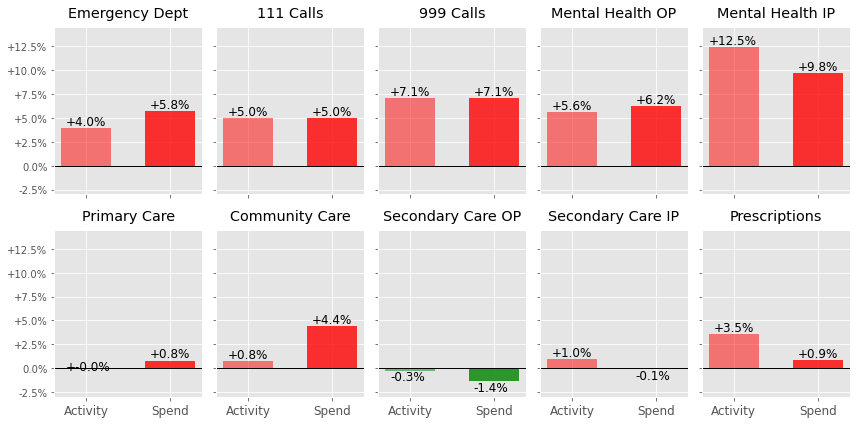

In [28]:

fig,ax = plt.subplots(2,5, figsize=(12,6), sharey='row', sharex='col')

ax_list = np.ravel(ax)
rgba_colors = np.zeros((2,4))
rgba_colors[:,0] = 1.0
rgba_colors[0,3] = 0.5
rgba_colors[1,3] = 0.8
rgba_colors1 = np.zeros((2,4))
rgba_colors1[0] = mpl.colors.to_rgba('g',alpha=0.5)
rgba_colors1[1] = mpl.colors.to_rgba('g',alpha=0.8)

sign2col = {1: rgba_colors, -1: rgba_colors1}

for i,ax in enumerate(ax_list[:]):
    
    n = to_plot.index.values[i]
    
    if n == '999 Calls':
        
        c1 = sign2col[np.sign(to_plot.iloc[i].values[0])][0]
        c2 = sign2col[np.sign(to_plot.iloc[i].values[0])][1]
    
        b = ax.bar(x = to_plot.columns.values, height = [to_plot.iloc[i].values[0],to_plot.iloc[i].values[0]], 
               color = [c1, c2], width=0.6)
        
        for r,rect in enumerate(b.patches): 

            w,h = rect.get_width(), rect.get_height()
            x0,y0 = rect.xy #lower left


            ax.text(x0 + w/10, h + 0.3,f'+{round(to_plot.iloc[i].values[0],1)}%' , fontsize=12)

    else:
        
        c1 = sign2col[np.sign(to_plot.iloc[i].values[0])][0]
        c2 = sign2col[np.sign(to_plot.iloc[i].values[1])][1]
        b = ax.bar(x = to_plot.columns.values, height = to_plot.iloc[i].values, color = [c1, c2], width=0.6)
    
        for r,rect in enumerate(b.patches): 

            w,h = rect.get_width(), rect.get_height()
            x0,y0 = rect.xy #lower left

            txt = round(to_plot.iloc[i].values[r],1)
            
            if txt>0 and txt < 10:
                
                ax.text(x0 + w/10, h + np.sign(h)*0.3,f'+{txt}%' , fontsize=12)
                
            elif txt == 0.0:
                
                ax.text(x0 + w/10, h + np.sign(h)*0.15,f'+{txt}%' , fontsize=12)
                
            elif txt>=10:
                
                ax.text(x0, h + np.sign(h)*0.3,f'+{txt}%' , fontsize=12)
                
            else:
                
                ax.text(x0 + w/10, h + np.sign(h),f'{txt}%' , fontsize=12)
        
    ax.set_title(n, pad=10)

    ax.set_xticklabels(['Activity','Spend'], rotation=0, fontsize=12)
    ax.set_ylim(-3,14.5)
    ax.set_yticks(ax.get_yticks())
    ax.set_yticklabels(labels = ['-5.0%','-2.5%', '0.0%', '+2.5%', '+5.0%', '+7.5%', '+10.0%', '+12.5%', '+15.0%'])
    ax.set_ylim(-3,14.5)

    ax.label_outer()
    ax.axhline(linewidth=1, color="k")

plt.tight_layout()

plt.savefig('plot_%change_letter.png', dpi=300)

plt.show()

## Variable Importances 

In [29]:
coef_files = [f for f in os.listdir() if fnmatch.fnmatch(f,'*_*_winter_coefficients.csv') 
             or fnmatch.fnmatch(f,'*_*_winter_ip_coefficients.csv') 
              or fnmatch.fnmatch(f,'*_*_winter_op_coefficients.csv')
              or fnmatch.fnmatch(f,'*_*_winter_ae_coefficients.csv')]

In [30]:
%%time

importance = pd.DataFrame(index = np.arange(1,11))

for fname in coef_files:

    file = pd.read_csv(fname, index_col=0).iloc[1:]

    col = (' ').join(fname.split('_')[:-1]).replace(' winter','')
    
    if col in ['act mh','act secondary', 'cost mh', 'cost secondary']:
        
        continue

    cs, prob = [],[]

    for imd in np.arange(1,11):
    
        imps = file[f'poisson_{imd}'].values
        cs.append(imps[0])
        prob.append(imps[1])

    importance[f'{col} cs'] = cs
    importance[f'{col} prob'] = prob

Wall time: 265 ms


### Activity models 

In [31]:
act = [c for c in importance.columns if 'act' in c]

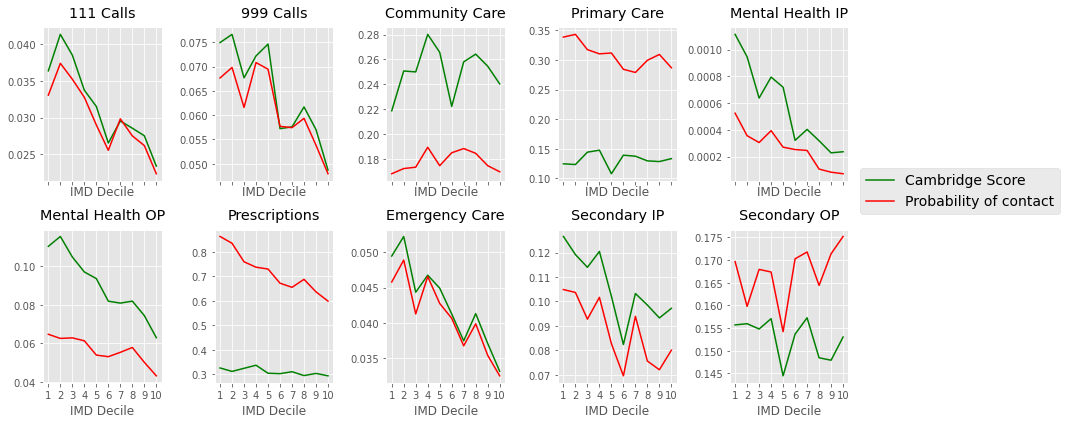

In [32]:
fig,ax = plt.subplots(2,5, figsize=(12,6), sharex='col')

ax_list = np.ravel(ax)
titles = []
for i, ax in enumerate(ax_list):
    
    j = i*2
    to_plot = importance[act[j:j+2]]
    to_plot.rename(columns = dict(zip(to_plot.columns, ['cs', 'p'])), inplace=True)
    
    #for c in to_plot.columns:
    #    to_plot[c] = to_plot[c]/to_plot.sum(axis=1)
        
    if i==9:
        
        ax.plot(np.arange(1,11),to_plot.cs, 'g-', label = 'Cambridge Score')
        ax.plot(np.arange(1,11),to_plot.p, 'r-', label = 'Probability of contact')

        
    else:
        ax.plot(np.arange(1,11),to_plot.cs, 'g-')
        ax.plot(np.arange(1,11),to_plot.p, 'r-')
    
    title = titles2new[(' ').join(act[j].split(' ')[1:-1])]
    
    ax.set_title(title, pad=10)
    
    ax.set_xticks(np.arange(1,11))
    ax.set_xlabel('IMD Decile')

    
plt.tight_layout()
plt.legend(loc=(1.1, 1.1), fontsize=14)
plt.show()

#### Comments 

For all healthcare settings the coefficients of $cs$ and $p$ vary with IMD. This justifies having a seperate model for each IMD decile and each healthcare setting.

For Primary Care, Prescriptions and Secondary OP, the probability of any contact is more important for determining the total number of contacts than a person's Cambridge Score.

For 111 Calls, 999 Calls and Emergency Care, both $cs$ and $p$ are of approximately equal importance in determining the total number of winter contacts. In these settings importance declines with IMD suggesting that Cambridge Score is reflective of the linear relationship between total number of contacts and IMD for these settings (see `Data Description`).

### Cost models 

In [33]:
cost = [c for c in importance.columns if 'cost' in c]

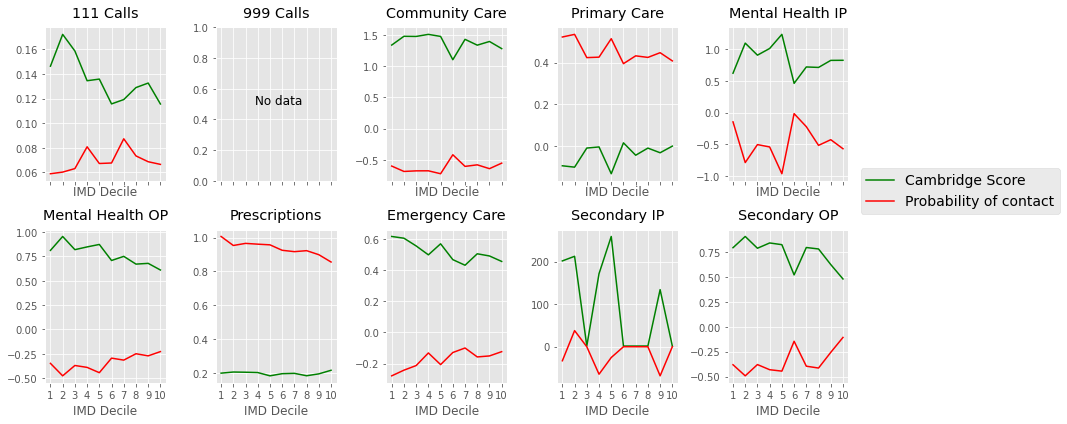

In [34]:
fig,ax = plt.subplots(2,5, figsize=(12,6), sharex='col')

ax_list = np.ravel(ax)
titles = []
for i, ax in enumerate(ax_list):
    
    if i==0:
        j = i*2
    else:
        j = (i-1)*2
        
    to_plot = importance[cost[j:j+2]]
    
    #for c in to_plot.columns:
    #    to_plot[c] = to_plot[c]/to_plot.sum(axis=1)
    
    to_plot.rename(columns = dict(zip(to_plot.columns, ['cs', 'p'])), inplace=True)
    
    if i==1:
        ax.set_title('999 Calls', pad=10)
        ax.text(3.8,0.5,'No data', fontsize=12)
        continue
    
    if i==9:
        
        ax.plot(np.arange(1,11),to_plot.cs, 'g-', label = 'Cambridge Score')
        ax.plot(np.arange(1,11),to_plot.p, 'r-', label = 'Probability of contact')

        
    else:
        ax.plot(np.arange(1,11),to_plot.cs, 'g-')
        ax.plot(np.arange(1,11),to_plot.p, 'r-')
    
    
    title = titles2new[(' ').join(cost[j].split(' ')[1:-1])]
    
    ax.set_title(title, pad=10)
    
    ax.set_xticks(np.arange(1,11))
    ax.set_xlabel('IMD Decile')
    
plt.tight_layout()
plt.legend(loc=(1.1, 1.1), fontsize=14)
plt.show()

#### Comments 

For all healthcare settings the coefficients of $cs$ and $p$ vary with IMD, however for some settings, noticeably Mental Health OP and Prescriptions, this variation is small.

For Primary Care and Prescriptions the probability of any contact is more important for determining the total number of contacts than a person's Cambridge Score.